# Project from scratch with Batchflow

In this tutorial, we show a complete machine learning project with Batchflow. We highly recommend reading our previous tutorials, as they explain key concepts used in this notebook in greater detail.

Content:
 * [Task and dataset description](#task_description)
 * [Model configuration](#model_conf)
 * [Training stage](#train) 
 * [Inference stage](#inference)
 * [Metrics](#metrics)
 * [Model representations](#model_representations)
 
And all these things we will make with Batchflow.
So, let's get started!

In [1]:
# Necessary imports
import sys
import warnings
from functools import partial
warnings.filterwarnings('ignore')

import numpy as np
from torch import nn
from matplotlib import pyplot as plt
plt.style.use('ggplot')

sys.path.append("../../../batchflow")
from batchflow import B, P, R, V, Pipeline
from batchflow import set_gpus, pylint_notebook
from batchflow.models.torch import Encoder
from batchflow.models.torch.blocks import ResBlock
from batchflow.opensets import ImageWoof2
from batchflow.research.utils import plot_images

_ = set_gpus(1)

`CUDA_VISIBLE_DEVICES` set to "7"


In [2]:
# Parameters
IMAGE_SHAPE = (192, 192)

EPOCH_NUM = 125
FREQUENCY = 50
BATCH_SIZE = 128

<a id='task_description'></a>
## Task and dataset description

We will train a model to **classify** dog breeds. 
We load the [second version of ImageWoof dataset](https://github.com/fastai/imagenette#imagewoof), containing 12833 pictures of ten dog breeds with different shapes, resolutions and waste objects.
You don't need to download the images by yourself because ImageWoof is already in Batchflow.

Let's take a closer look at the pictures.

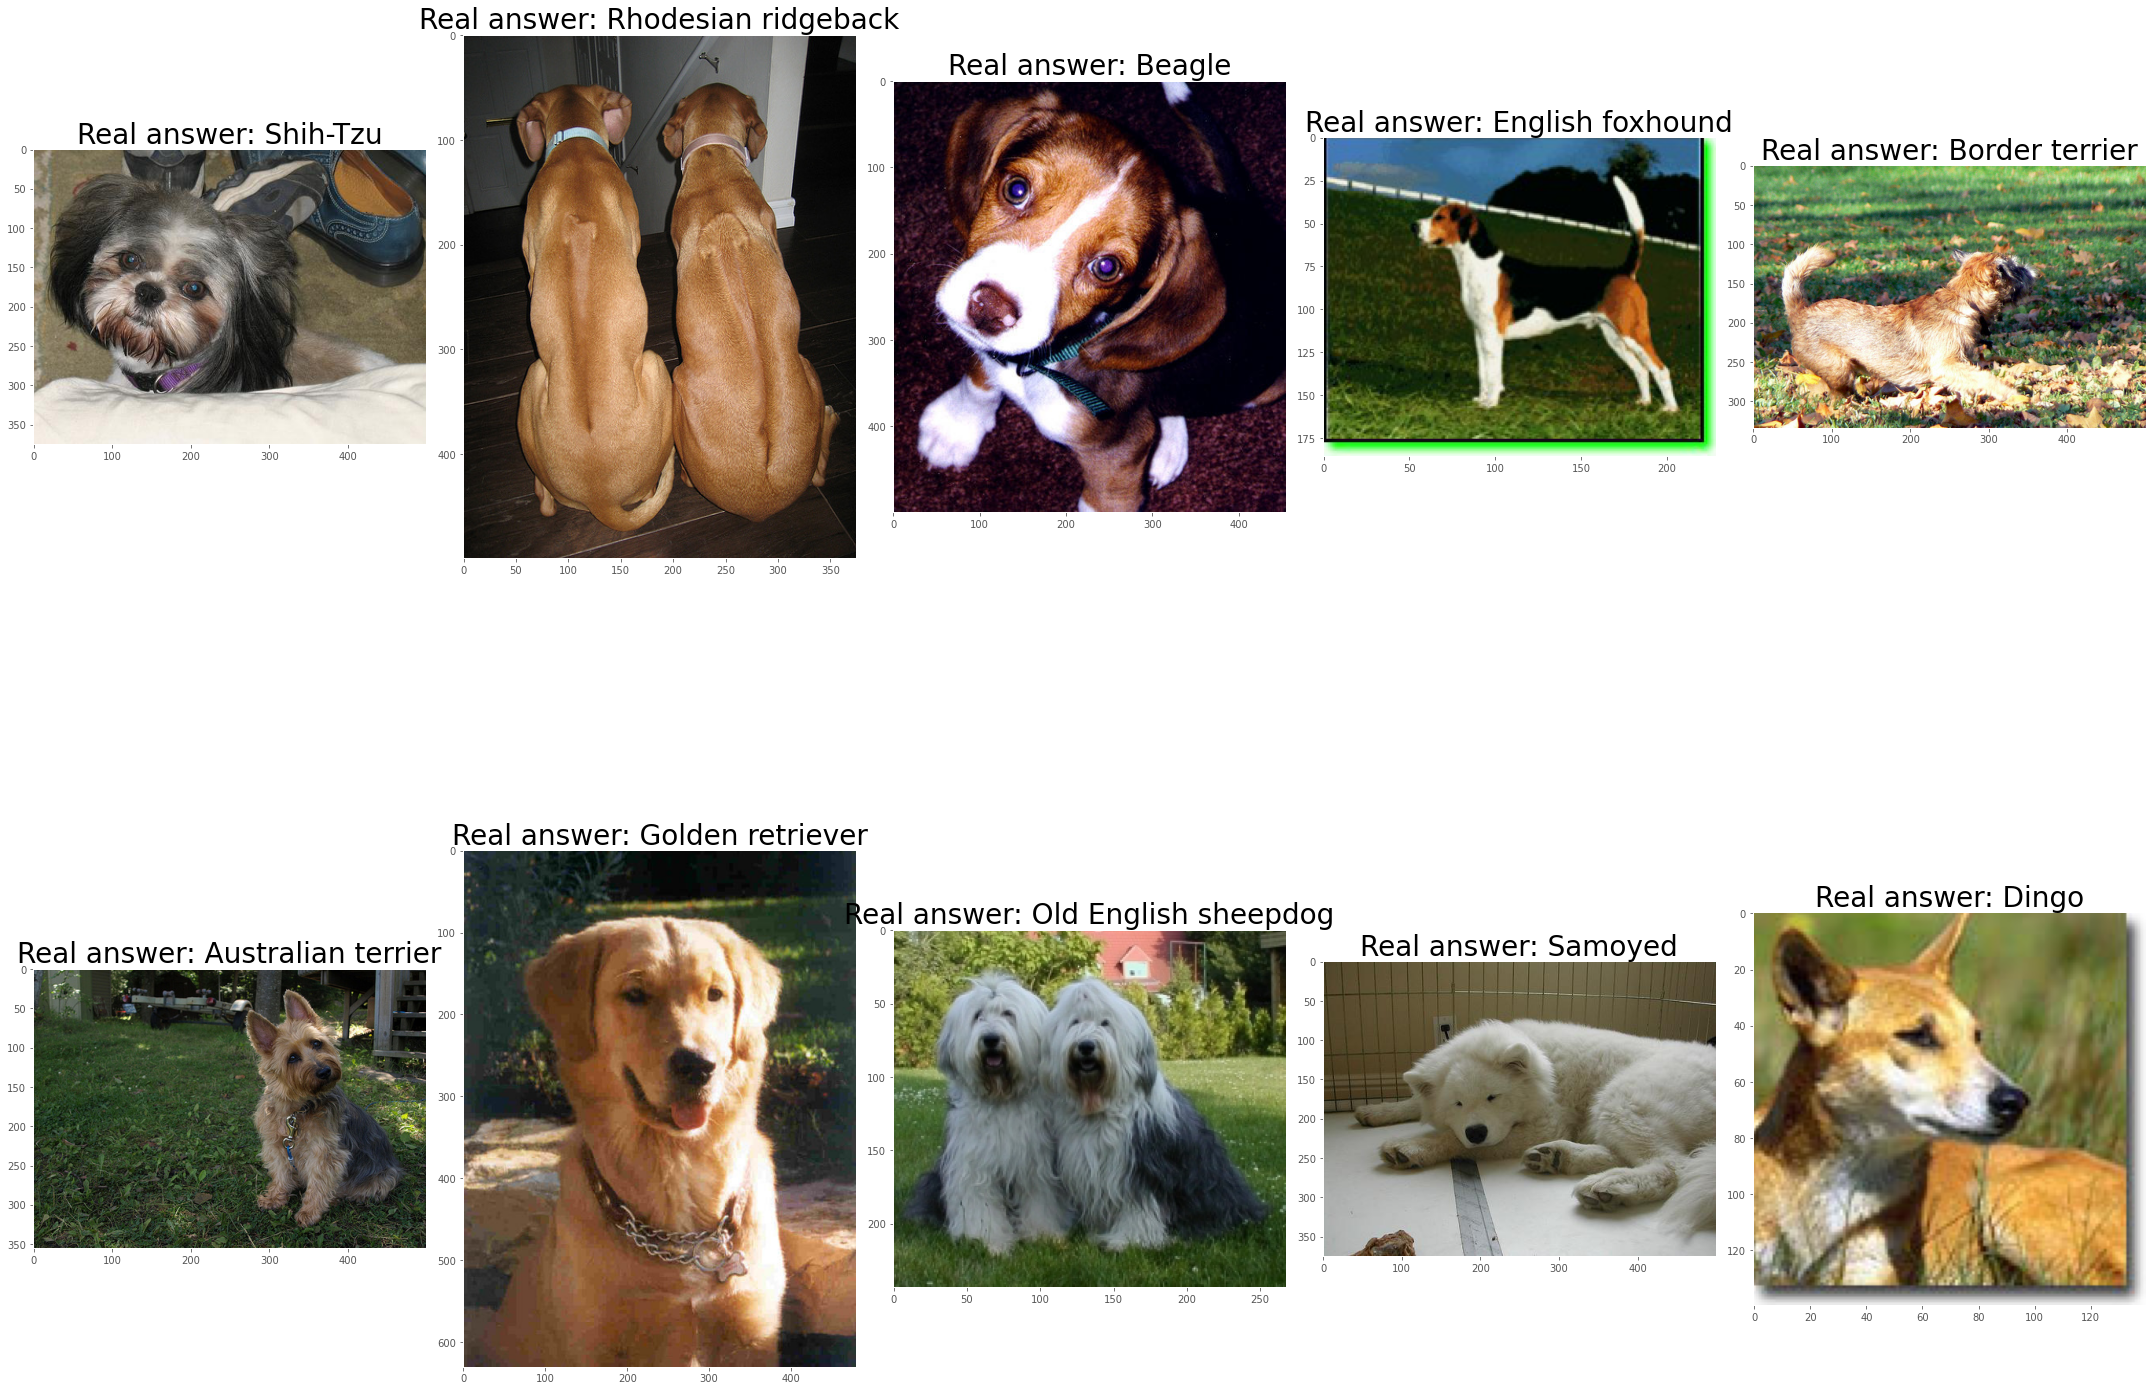

In [3]:
dataset = ImageWoof2()

classes = [
    "Shih-Tzu", "Rhodesian ridgeback", "Beagle", "English foxhound", "Border terrier",
    "Australian terrier", "Golden retriever", "Old English sheepdog", "Samoyed", "Dingo"
]

pic_idx = [np.argwhere(dataset.preloaded[1]==i)[0][0] for i in range(len(classes))]
plot_images(images=dataset.preloaded[0][pic_idx],
            labels=dataset.preloaded[1][pic_idx],
            ncols=5, classes=classes, figsize=(30, 35), tight_layout=True)

<a id='model_conf'></a>
## Model configuration

We start the solution with neural network creation.
We will describe an **XResNet50** model which contains:
* **initial_block** - block containing the input layers (input stem);
* **body** - the main part of the model;
* **head** - output layers, like global average pooling or dense layers.

An **XResNet50** is a [**ResNet50** model](https://arxiv.org/pdf/1512.03385.pdf) with several modifications from [bag-of-tricks](https://arxiv.org/abs/1812.01187) article: 
 * we replace an input stem with a **ResNet-C** block;
 * as a **Downsample ResBlock** we use a **ResNet-D** block;
 * we modify model weights and bias initialization.
 
An **XResNet50 model config** in Batchflow is:

In [4]:
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.optimizer import ranger
from fastai.vision.all import Mish

model_config = {
    # Model info:
    'inputs/images/shape': (3, *IMAGE_SHAPE),
    'inputs/labels/classes': 10,
    'initial_block/inputs': 'images',
    'channels': 'first',

    # Model architecture:
    'initial_block' : {
        'layout': 'cna cna cna p',
        'filters': [32, 32, 64],
        'kernel_size': 3,
        'strides': [2, 1, 1],
        'pool_size': 3,
        'pool_strides': 2,
        'activation': Mish,
        'padding': 1
    },

    'body/encoder' : {
        'num_stages': 16,
        'order': ['block'],
        'blocks': {
            'base': ResBlock,
            'layout': 'cn',
            'filters': [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3,
            'bottleneck': True,
            'attention': [False, False, 'ssa'] + [False] * 13,
            'strides': [1] * 3 + ([2] + [1] * 3) + ([2] + [1] * 5) + ([2] + [1] * 2),
            'branch': [{
                'layout': layout,
                'stride': 1
            } for layout in ['cn'] * 3 + (['vcn'] + ['cn'] * 3) + \
                            (['vcn'] + ['cn'] * 5) + (['vcn'] + ['cn'] * 2)],
            'activation': Mish
        }
    },

    'head' : dict(layout='Vf'),

    # Model training details:
    'loss': LabelSmoothingCrossEntropy(),
    'optimizer': partial(ranger, lr=8e-3, mom=0.95, sqr_mom=0.99, eps=1e-6, beta=0., wd=1e-2),
    'output': {'predicted': ['proba', 'labels']}
}

In a model config, we can define **loss** and **optimizer** from Batchflow or other libraries, and here you see the second case example.

Next, we initialize **model weights** for better performance.

In [5]:
model = Encoder(model_config)

for module in model.model.modules():
    if getattr(module, 'bias', None) is not None:
        nn.init.constant_(module.bias, 0)
    if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        nn.init.kaiming_normal_(module.weight)

<a id='train'></a>
## Train stage

After the model creation, we can define the training procedure as a sequence of **pipelines**.

In [6]:
# Images preprocessing
load_pipeline = (
    Pipeline()
    .resize(size=IMAGE_SHAPE, src=['images'], dst=['images'])
    .to_array(channels='first', dtype=np.float32)
    .multiply(multiplier=1/255)
)

# Images augmentations
augment_pipeline = (
    Pipeline()
    .flip(mode=P(R(['lr', 'ud'])), p=0.5)
    .crop(origin=P(R('uniform', 0, 1-1e-7, size=2)),
          shape=P(R('integers', int(IMAGE_SHAPE[0]*0.8), IMAGE_SHAPE[0], size=2)),
          crop_boundaries=False, p=0.3)
    .shift(offset=P(R('integers', 20, size=2)), p=0.5)
)

# Model initialization and training instructions
train_model_pipeline = (
    Pipeline()
    .init_variable('loss_history', [])
    .init_model('xresnet50', source=model)
    .train_model('xresnet50', fetches='loss',
                 images=B('images'), targets=B('labels'),
                 save_to=V('loss_history', mode='a'))
)

# Full training pipeline definition
train_pipeline = (
    augment_pipeline + \
    load_pipeline + \
    train_model_pipeline
) << dataset.train

Training pipeline is a combination of image **preprocessing**, **augmentations**, and **training process** instructions. 
Augmented images have the following look:

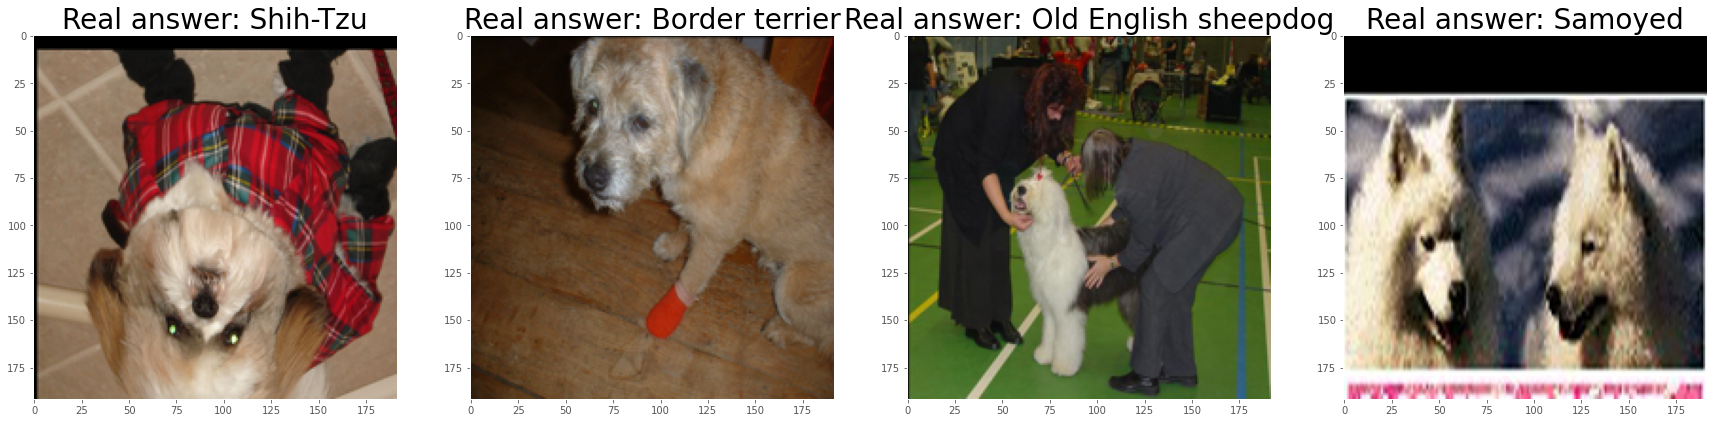

In [7]:
batch = train_pipeline.next_batch(4, shuffle=True)
plot_images(np.transpose(batch.images, (0, 2, 3, 1)), batch.labels,
            classes=classes, ncols=4, figsize=(30, 35))

Pipelines in Batchflow are <u>lazy</u>, so we need to call the ```'run'``` method to execute them. The ```'run'``` has additional parameters that allow us to:

* Track the **loss function** (or any other entity) changes during training with a ```notifier```. We can use it for early stopping, as well as for general awareness about pipeline execution.

* Get resource utilization info with a **resources monitor**. This information makes the training process more effective: if you have free **GPU Memory** and **GPU** is not too busy, you can increase batch or model size.

* Inspect timings for all pipeline actions with [pipelines profiling](./08_profiling.ipynb).

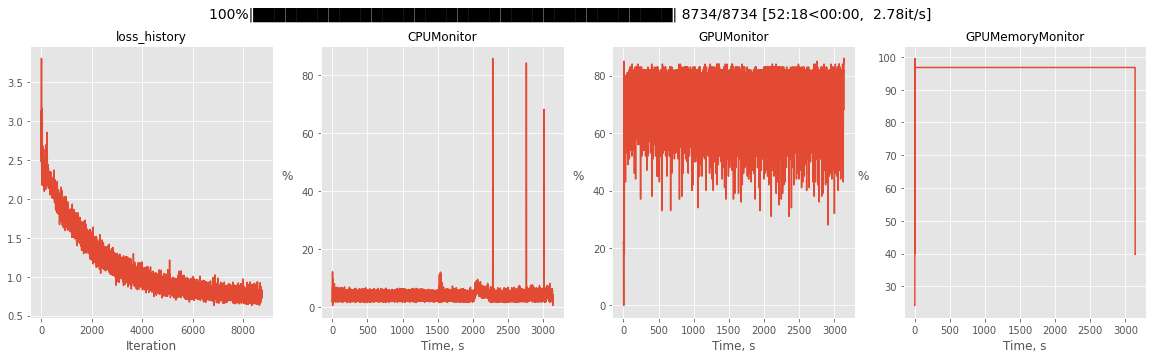

In [8]:
notifier = {
    'bar': 'n', 'frequency': FREQUENCY,
    'graphs': ['loss_history', 'cpu', 'gpu', 'gpu_memory'],
    'file': './logs/notifier_log.txt',
    'savepath': './logs/notifier_visualization'
}

_ = train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=EPOCH_NUM, shuffle=True,
                       prefetch=10, notifier=notifier)

Model training is successful: **loss function decreases, last iterations have similar loss values, and we use resources efficiently**.

<a id='inference'></a>
## Inference stage

After training, we want to understand how effective the model is.
Thus, the next step is the **model quality measurement**: we define an inference pipeline and compute metrics on the test set.

Two main **differences between inference and training pipelines** are:
 * inference pipeline doesn't need images augmentations;
 * we must provide metrics definitions in the inference pipeline.

<a id='metrics'></a>
### Metrics

Firstly, we describe and execute an **inference pipeline**.

In [9]:
# Model import and getting predictions
model_inference_pipeline = (
    Pipeline()
    .import_model('xresnet50', train_pipeline)
    .predict_model('xresnet50', images=B('images'),
        fetches='predictions',
        save_to=V('predictions'))
)

# Metrics definitions
metrics_pipeline = (
    Pipeline()
    .init_variables('predictions', 'metrics')
    .gather_metrics('classification', targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', num_classes=10, axis=1, save_to=V('metrics', mode='update'))
)

# Full inference pipeline
test_pipeline = (
    load_pipeline + \
    model_inference_pipeline + \
    metrics_pipeline
) << dataset.test

_ = test_pipeline.run(batch_size=2*BATCH_SIZE, drop_last=False, bar='t')

100%|███████████████████████████████████████████| 16/16 [00:31<00:00,  1.97s/it]


The pipeline saved information about the **confusion matrix**, and now we can evaluate specific **metrics** from it: possible options are F-measure, accuracy, sensitivity, and more. You can find the description of all available metrics in [the documentation](https://analysiscenter.github.io/batchflow/api/batchflow.models.metrics.html).

In [10]:
f1_scores = test_pipeline.v('metrics').evaluate('f1_score', agg='mean', multiclass=None)
print("F1 score for each class:")
print(f1_scores,'\n')
print("Mean F1 score: ", np.mean(f1_scores))

accuracy = test_pipeline.v('metrics').evaluate('accuracy')
print("Accuracy: ", accuracy)

F1 score for each class:
[0.80532044 0.82897862 0.72595657 0.62365591 0.80099502 0.81671159
 0.79294118 0.79778393 0.88838782 0.78487614] 

Mean F1 score:  0.7865607228411091
Accuracy:  0.7953727506426735


Metrics values look decent: **the model often makes accurate predictions**. 
We visualize the confusion matrix for getting detailed information about mismatches.

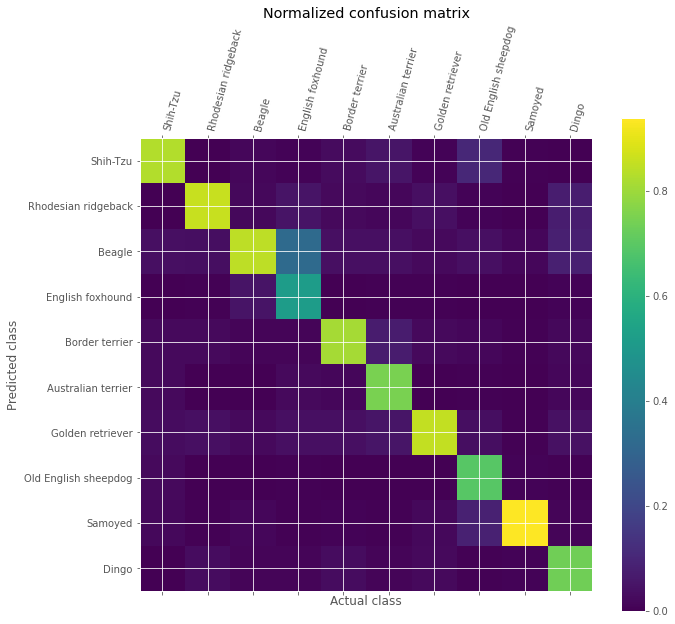

In [11]:
confusion_matrix = np.array(test_pipeline.v('metrics').confusion_matrix)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(confusion_matrix/np.nansum(confusion_matrix, axis=0))
ax.set_xticks(np.arange(confusion_matrix.shape[0]))
ax.set_xticklabels(classes, rotation=75, ha="left")
ax.set_xlabel("Actual class")
ax.set_yticks(np.arange(confusion_matrix.shape[0]))
ax.set_yticklabels(classes)
ax.set_ylabel("Predicted class")
fig.colorbar(im, ax=ax, shrink=0.8)
ax.set_title("Normalized confusion matrix")
fig.tight_layout()
plt.show()

The model is most often confused with Beagles and English foxhounds. If you look at pictures of these breeds, you will find that they are similar.

### Visualizations

Of course, it's always interesting to look at some images and model predictions.

In [12]:
# Inference pipeline with probabilities
proba_predictions_pipeline = (
    Pipeline()
    .init_variables('proba', 'labels', 'predictions')
    .predict_model('xresnet50', images=B('images'),
    fetches=['predicted_proba', 'predicted_labels'],
    save_to=[V('proba'), V('labels')])
)

inference_pipeline = (
    load_pipeline + \
    model_inference_pipeline + \
    proba_predictions_pipeline
) << dataset.test

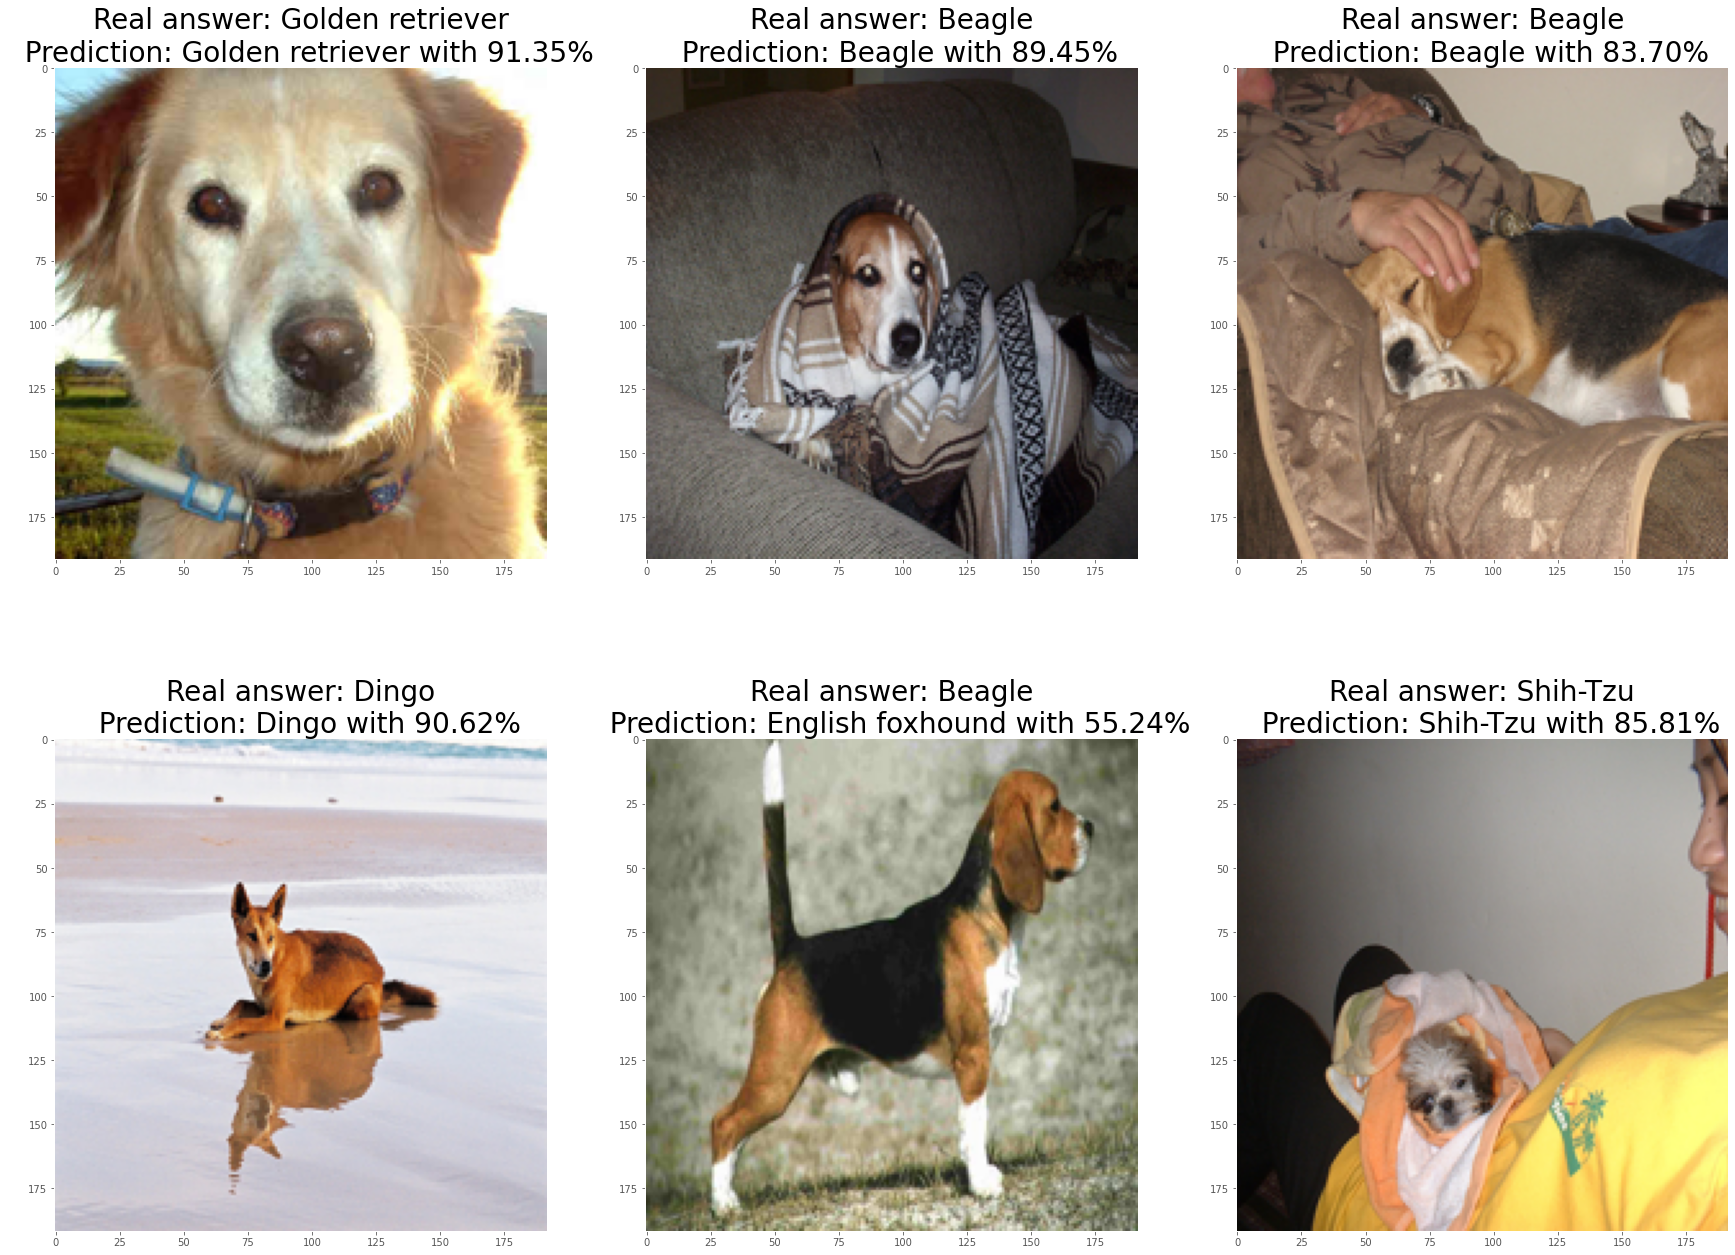

In [13]:
batch = inference_pipeline.next_batch(6, shuffle=True)

plot_images(np.transpose(batch.images, (0, 2, 3, 1)), batch.labels,
            batch.pipeline.v('proba'),  classes=classes, ncols=3, figsize=(30, 35))

From these examples, the model predicts actual labels with high probability. So, **the model recognizes some dog breeds very well**.

<a id='model_representations'></a>
## Model representations

The other curious thing is **model representations**. Batchflow has methods for getting model underlying representations to understand how the model perceives the data. This information aid in making model development decisions.

Let's take a look at some insights from **self-attention**. As an **exercise**, you can compare two models with and without self-attention to understand how helpful it is.

In [14]:
model = train_pipeline.get_model_by_name('xresnet50')
module = model.model[1][0]['block-2']

We can look at pictures representations that show how the model parts operate with the data.

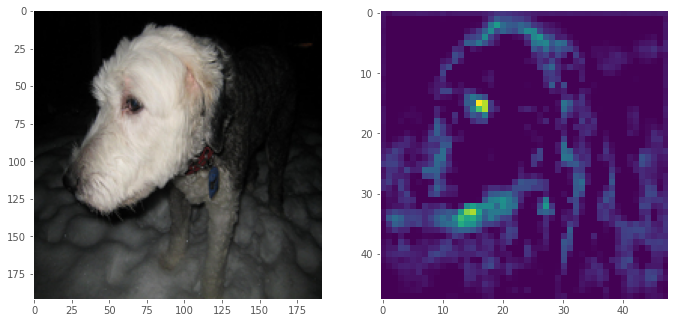

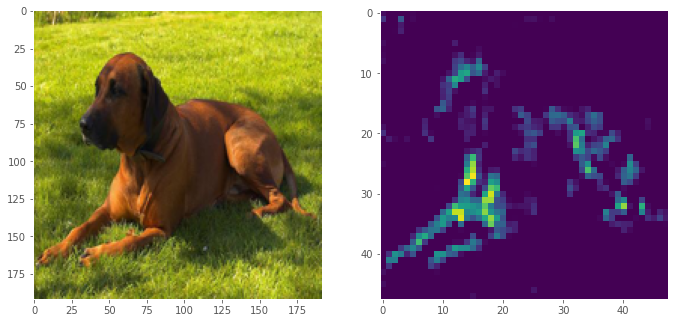

In [25]:
images_num = 2
batch = inference_pipeline.next_batch(images_num, shuffle=True)
for image_num in range(images_num):
    image = np.transpose(batch.images[image_num], (1, 2, 0))
    cam = model.get_gradcam(images=batch.images[image_num:image_num+1], layer=module)
    plot_images((image.reshape(*image.shape), cam.reshape(*cam.shape, 1)), figsize=(30, 35))

**[Gradcam](https://arxiv.org/pdf/1610.02391.pdf)** highlights **key features** in images.
If the model has good metrics values but strange key features on images -  it's a reason to improve it.
We see that the model on this layer mostly found pictures parts with dogs. This result is what we wanted.

The callable to run the **pylint** tool in **Jupyter Notebook** is a cherry on the cake of this tutorial:

In [16]:
pylint_notebook()

Your code has been rated at 2.95/10 (previous run: 2.95/10, +0.00)
------------------------------------------------------------------



0

Zero exit code means **no critical errors**. The overall **rating of the code** depends on style guides, that are not important for Jupyter Notebook, so we don't get the highest mark.

# Conclusion

**In this tutorial, you:**
 * learned how to handle training and inference processes efficiently; 
 * found out ways to get model insights to improve your solutions.

# What's next?

After this tutorial, you can easily solve classification challenges with Batchflow. 
**For starters**, you can try other model configurations and augmentations to improve the current solution and achieve better metrics values.